# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Data Augmentation

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


# Patch Embedding

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=2, in_channels=3, embed_dim=128):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x


# Transformer Encoder Block

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


# Vision Transformer Model

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=2,
                 embed_dim=128, num_heads=4,
                 num_layers=6, num_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim)
        )

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        x = x.transpose(0, 1)
        for block in self.blocks:
            x = block(x)
        x = x.transpose(0, 1)

        x = self.norm(x)
        return self.head(x[:, 0])


# Model, Loss and Optimizer

In [7]:
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


# Training Loop

In [8]:
epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/30] Loss: 1.8582
Epoch [2/30] Loss: 1.5610
Epoch [3/30] Loss: 1.3921
Epoch [4/30] Loss: 1.2870
Epoch [5/30] Loss: 1.1955
Epoch [6/30] Loss: 1.1390
Epoch [7/30] Loss: 1.0837
Epoch [8/30] Loss: 1.0384
Epoch [9/30] Loss: 1.0047
Epoch [10/30] Loss: 0.9626
Epoch [11/30] Loss: 0.9381
Epoch [12/30] Loss: 0.9123
Epoch [13/30] Loss: 0.8830
Epoch [14/30] Loss: 0.8566
Epoch [15/30] Loss: 0.8392
Epoch [16/30] Loss: 0.8212
Epoch [17/30] Loss: 0.7960
Epoch [18/30] Loss: 0.7761
Epoch [19/30] Loss: 0.7654
Epoch [20/30] Loss: 0.7416
Epoch [21/30] Loss: 0.7322
Epoch [22/30] Loss: 0.7110
Epoch [23/30] Loss: 0.6902
Epoch [24/30] Loss: 0.6796
Epoch [25/30] Loss: 0.6621
Epoch [26/30] Loss: 0.6500
Epoch [27/30] Loss: 0.6365
Epoch [28/30] Loss: 0.6211
Epoch [29/30] Loss: 0.6090
Epoch [30/30] Loss: 0.5936


# Evaluation

In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")



Test Accuracy: 75.93%


# Demo

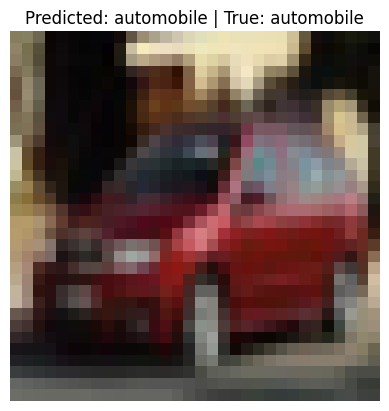

In [10]:
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

model.eval()
idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[idx]

with torch.no_grad():
    output = model(image.unsqueeze(0).to(device))
    _, pred = torch.max(output, 1)

predicted_class = classes[pred.item()]
true_class = classes[label]

img = image.permute(1, 2, 0).numpy()
img = (img * 0.5) + 0.5
img = np.clip(img, 0, 1)

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class} | True: {true_class}")
plt.show()
